# Расчёт ожидаемых потерь по ссудам с использованием метода Монте-Карло

В данной задаче проводится оценка ожидаемых потерь (*Expected Loss*, EL) по кредитному портфелю с применением метода Монте-Карло. Формула для расчёта ожидаемых потерь:

$$
EL = EAD \cdot PD \cdot LGD
$$

где:

- **EAD (Exposure at Default)** — сумма непогашенного кредита на момент наступления дефолта.
- **PD (Probability of Default)** — вероятность дефолта заемщика.
- **LGD (Loss Given Default)** — доля убытков при дефолте, учитывающая наличие обеспечения или гарантий.

### Моделирование параметров:

- **PD** генерируется с помощью **логнормального распределения**, параметризованного математическим ожиданием (`PD_mean`) и стандартным отклонением (`PD_sigma`). Это распределение удобно тем, что принимает только положительные значения, что соответствует природе вероятности.

- **LGD** моделируется с использованием **beta-PERT распределения**, которое задаётся тремя параметрами:
    - минимальным значением,
    - наиболее вероятным значением,
    - максимальным значением.


In [5]:
# 1) импорт библиотек 
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt

# 2) Начальные параметры
np.random.seed(42)

EAD_A = 1000
EAD_B = 2000
EAD_C = 2500

PD_mean_A, PD_std_A = 0.02, 0.007
PD_mean_B, PD_std_B = 0.01, 0.005
PD_mean_C, PD_std_C = 0.015, 0.01

LGD_A_min, LGD_A_mode, LGD_A_max = 0.0, 0.2, 1.0
LGD_B_min, LGD_B_mode, LGD_B_max = 0.0, 0.3, 1.0
LGD_C_min, LGD_C_mode, LGD_C_max = 0.0, 0.4, 1.0

N = 50000

# Моделирование PD через логнормальное распределение

### Зачем это нужно?

**PD (Probability of Default)** — вероятность дефолта заёмщика. Она всегда положительна и часто имеет "скошенное" распределение. Логнормальное распределение хорошо подходит для моделирования таких вероятностей, так как порождает только положительные значения и позволяет учесть асимметрию.

---

### Как устроено логнормальное распределение?

Если случайная величина \\( X \\) имеет нормальное распределение, то её график представляет собой классический "колокол" — симметричную кривую. Если применить экспоненциальное преобразование \\( Y = e^X \\), то \\( Y \\) будет иметь логнормальное распределение — уже асимметричное и строго положительное.

## Вывод формул для параметров логнормального распределения

Эти формулы получаются из стандартных свойств логнормального распределения, связывающих \\( PD\_mean \\) и \\( PD\_sigma \\) с параметрами \\( \mu \\) и \\( \sigma^2 \\) нормального распределения.

### Свойства логнормального распределения

1. **Математическое ожидание**:

$$
PD\_mean = \exp\left( \mu + \frac{\sigma^2}{2} \right)
$$

2. **Стандартное отклонение**:

$$
PD\_sigma = \sqrt{(e^{\sigma^2} - 1) \cdot PD\_mean^2}
$$

### Шаг 1: Находим \\( \sigma^2 \\)

Из формулы стандартного отклонения:

$$
\frac{PD\_sigma^2}{PD\_mean^2} = e^{\sigma^2} - 1
$$

Отсюда:

$$
e^{\sigma^2} = 1 + \left( \frac{PD\_sigma}{PD\_mean} \right)^2
$$

$$
\sigma^2 = \ln\left(1 + \left( \frac{PD\_sigma}{PD\_mean} \right)^2\right)
$$

А если нужно сразу \\( \sigma \\):

$$
\sigma = \sqrt{\ln\left(1 + \left( \frac{PD\_sigma}{PD\_mean} \right)^2\right)}
$$

### Шаг 2: Находим \\( \mu \\)

Подставляем \\( \sigma^2 \\) в формулу для ожидания:

$$
\mu = \ln(PD\_mean) - \frac{\sigma^2}{2}
$$

---

## Моделирование LGD с использованием beta-PERT распределения

Для моделирования **Loss Given Default (LGD)** удобно использовать beta-PERT распределение. Оно учитывает экспертные оценки:

- **LGD-min** — минимально возможное значение
- **LGD-mode** — наиболее вероятное (мода)
- **LGD-max** — максимально возможное значение

### Формулы для параметров \\( \alpha \\) и \\( \beta \\):

$$
\alpha = 1 + 4 \cdot \frac{\text{LGD-mode} - \text{LGD-min}}{\text{LGD-max} - \text{LGD-min}}
$$

$$
\beta = 1 + 4 \cdot \frac{\text{LGD-max} - \text{LGD-mode}}{\text{LGD-max} - \text{LGD-min}}
$$


ИТОГИ СИМУЛЯЦИИ (N = 50000):
 - Медиана потерь: 26.38
 - Среднее значение потерь: 29.54
 - 95-й перцентиль потерь: 57.81


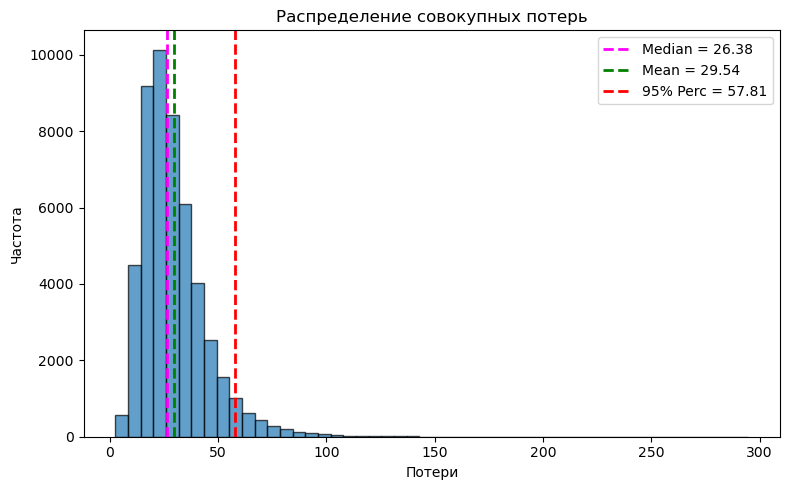

In [7]:
### 3) Генерация PD для каждого займа (логнормальное распределение)
# Используем преобразование mean и std в параметры lognormal (mu, sigma)
# sigma^2 = ln( (std / mean)^2 + 1 )
# mu      = ln(mean) - sigma^2 / 2

# Займ A:
sigma2_A = np.log((PD_std_A / PD_mean_A) ** 2 + 1)
sigma_A = np.sqrt(sigma2_A)
mu_A = np.log(PD_mean_A) - sigma2_A / 2
pdA = np.exp(mu_A + sigma_A * np.random.randn(N))
pdA = np.clip(pdA, 0, 1)   # ограничиваем pd в пределах [0, 1]

# Займ B:
sigma2_B = np.log((PD_std_B / PD_mean_B) ** 2 + 1)
sigma_B = np.sqrt(sigma2_B)
mu_B = np.log(PD_mean_B) - sigma2_B / 2
pdB = np.exp(mu_B + sigma_B * np.random.randn(N))
pdB = np.clip(pdB, 0, 1)

# Займ C:
sigma2_C = np.log((PD_std_C / PD_mean_C) ** 2 + 1)
sigma_C = np.sqrt(sigma2_C)
mu_C = np.log(PD_mean_C) - sigma2_C / 2
pdC = np.exp(mu_C + sigma_C * np.random.randn(N))
pdC = np.clip(pdC, 0, 1)

### 4) Генерация LGD для каждого займа (распределение beta-PERT)
# Определяем параметры бета-распределения на основе min, mode, max
# alpha = 1 + 4 * (mode - min) / (max - min)
# beta  = 1 + 4 * (max - mode) / (max - min)

# Займ A:
alpha_A = 1 + 4 * (LGD_A_mode - LGD_A_min) / (LGD_A_max - LGD_A_min)
beta_A = 1 + 4 * (LGD_A_max - LGD_A_mode) / (LGD_A_max - LGD_A_min)
lgdA = LGD_A_min + (LGD_A_max - LGD_A_min) * np.random.beta(alpha_A, beta_A, N)

# Займ B:
alpha_B = 1 + 4 * (LGD_B_mode - LGD_B_min) / (LGD_B_max - LGD_B_min)
beta_B = 1 + 4 * (LGD_B_max - LGD_B_mode) / (LGD_B_max - LGD_B_min)
lgdB = LGD_B_min + (LGD_B_max - LGD_B_min) * np.random.beta(alpha_B, beta_B, N)

# Займ C:
alpha_C = 1 + 4 * (LGD_C_mode - LGD_C_min) / (LGD_C_max - LGD_C_min)
beta_C = 1 + 4 * (LGD_C_max - LGD_C_mode) / (LGD_C_max - LGD_C_min)
lgdC = LGD_C_min + (LGD_C_max - LGD_C_min) * np.random.beta(alpha_C, beta_C, N)

### 5) Расчёт совокупных потерь (по формуле: Loss = EAD * PD * LGD)

lossA = EAD_A * pdA * lgdA
lossB = EAD_B * pdB * lgdB
lossC = EAD_C * pdC * lgdC

total_losses = lossA + lossB + lossC

### 6) Статистики по результатам симуляции

median_loss = np.median(total_losses)
mean_loss = np.mean(total_losses)
perc95_loss = np.percentile(total_losses, 95)

### 7) Визуализация результатов

print(f"ИТОГИ СИМУЛЯЦИИ (N = {N}):")
print(f" - Медиана потерь: {median_loss:.2f}")
print(f" - Среднее значение потерь: {mean_loss:.2f}")
print(f" - 95-й перцентиль потерь: {perc95_loss:.2f}")

plt.figure(figsize=(8, 5))
plt.hist(total_losses, bins=50, edgecolor='black', alpha=0.7)

plt.axvline(median_loss, color='magenta', linestyle='--', linewidth=2, label=f'Median = {median_loss:.2f}')
plt.axvline(mean_loss, color='green', linestyle='--', linewidth=2, label=f'Mean = {mean_loss:.2f}')
plt.axvline(perc95_loss, color='red', linestyle='--', linewidth=2, label=f'95% Perc = {perc95_loss:.2f}')

plt.legend()
plt.title("Распределение совокупных потерь")
plt.xlabel("Потери")
plt.ylabel("Частота")
plt.tight_layout()
plt.show()
